# Standard Python Libraries

In [2]:
### Display
from IPython.display import display
## Data Handling
import pandas as pd

# Process Mining
In the lecture, basic concepts of Process Mining such as processes, events, event data, and process models in terms of process trees or Petri nets have been introduced. Besides, you learned about two fundamental Process Mining problems, that is **process discovery** - an unsupervised task - and **Conformance Checking** - a supervised task.

**Dokumentation:** https://pm4py.fit.fraunhofer.de/documentation

Many of these concepts have been implemented in the Python Process Mining suite PM4Py that is developed here in Aachen by the Fraunhofer Process Mining team.

# Imports

In [3]:
import pm4py
print(pm4py.__version__)

2.2.27


If the import does not cause error messages and the version is displayed (2.2.x for the provided environment), you are ready to go.

*Side Note:*
*To allow for flexibility in the code and, more importantly, to allow for implementations of different versions of algorithms PM4py heavily relies on the **factory** design pattern: https://en.wikipedia.org/wiki/Factory_(object-oriented_programming). While in 'older' versions the factories had to be used in the API, the current version offers a **simplified interface** that allows for much shorter code.*
## Importing logs
Let's start from the acquisition of an event log from a file. In this case, we are going to use the importer for the XES format.

The XES format (eXtensible Event Stream) is a de-facto standard in Process Mining, and many of the well-known event logs available in the community and in academic research have this format. The format is XML-based and, therefore, everything but light-weight ;); however, it support many concepts that go beyond the lecture.

In [4]:
log = pm4py.read_xes('roadtraffic50traces.xes') 

parsing log, completed traces ::   0%|          | 0/51 [00:00<?, ?it/s]

The `log` object is iterable, so you can treat it as a list (of traces) (in fact, it is closer to `collections.abc.Sequence`).
Each  trace can be treated as a Map that contains the keys: `attributes`, a dictionary of trace attributes; `properties`, a dictionary of properties (rarely used); and `events`, the list of events. 

**Caveat**: in order to promote simplicity, the behaviour of the `trace` class is a list of events. Do not be fooled by the visualization! The method `trace.attributes` returns a dictionary that stores the key-value pairs of the trace attributes.

This way, you are able to manipulate logs, traces and events using the basic operations on sequences, lists, and dictionaries that we showed in the second instruction (about Python).

In [5]:
print(log[0])
print(len(log))

{'attributes': {'concept:name': 'A1'}, 'events': [{'amount': 35.0, 'org:resource': '561', 'dismissal': 'NIL', 'concept:name': 'Create Fine', 'vehicleClass': 'A', 'totalPaymentAmount': 0.0, 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2006, 7, 24, 0, 0), 'article': 157, 'points': 0}, '..', {'concept:name': 'Send Fine', 'lifecycle:transition': 'complete', 'expense': 11.0, 'time:timestamp': datetime.datetime(2006, 12, 5, 0, 0)}]}
51


## Importing CSV-files

Often event logs are given as csv-files. In this case, you need to specifiy how columns are mapped to the case id, the activities, and the timestamps. Here, the **simplified interface** helps a lot.

In [5]:
#import the csv-file example.csv
df = pd.read_csv('log.csv', sep=',')
display(df.head())
df = pm4py.format_dataframe(df, case_id='Patient', activity_key='Activity', timestamp_key='Timestamp') # Simplified interface. Does the formating for you
# Let's see what this does
display(df.head())
log = pm4py.convert_to_event_log(df)


Timestamp  Patient                Activity Lifecycle  ModelTime  \
0  2020-06-01 06:08:53        1                Register  complete        533   
1  2020-06-01 06:28:03        1            Initial Exam  complete       1683   
2  2020-06-01 06:34:17        1   Initial Exam Decision  complete       2057   
3  2020-06-01 06:35:59        1  Inform about Isolation  complete       2159   
4  2020-06-01 07:05:17        1                Test III  complete       3917   

      PatientName  Age Insurance  Resource  Type  
0  Philipp the 1.   68      STAT     F0-A1   NaN  
1  Philipp the 1.   68      STAT     F0-A5   NaN  
2  Philipp the 1.   68      STAT  F0-D1-A5   NaN  
3  Philipp the 1.   68      STAT     F0-A3   NaN  
4  Philipp the 1.   68      STAT     F0-A3   NaN

Timestamp  Patient                Activity Lifecycle  \
0 2020-06-01 06:08:53+00:00        1                Register  complete   
1 2020-06-01 06:28:03+00:00        1            Initial Exam  complete   
2 2020-06-01 06:34:17+00:00        1   Initial Exam Decision  complete   
3 2020-06-01 06:35:59+00:00        1  Inform about Isolation  complete   
4 2020-06-01 07:05:17+00:00        1                Test III  complete   

   ModelTime     PatientName  Age Insurance  Resource  Type case:concept:name  \
0        533  Philipp the 1.   68      STAT     F0-A1   NaN                 1   
1       1683  Philipp the 1.   68      STAT     F0-A5   NaN                 1   
2       2057  Philipp the 1.   68      STAT  F0-D1-A5   NaN                 1   
3       2159  Philipp the 1.   68      STAT     F0-A3   NaN                 1   
4       3917  Philipp the 1.   68      STAT     F0-A3   NaN                 1   

             concept:name            time:timestamp  @@index  
0                Register 2020-06-01 06:08:53+00:00        0  
1            Initial Exam 2020-06-01 06:28:03+00:00        1  
2   Initial Exam Decision 2020-06-01 06:34:17+00:00        2  
3  Inform about Isolation 2020-06-01 06:35:59+00:00        3  
4                Test III 2020-06-01 07:05:17+00:00        4

In [6]:
#give statistics
print(f'Number of traces: {len(log)}')

Number of traces: 1500


# Filtering
When analyzing processes, it is usually very common to focus on different aspects of the process separately. Therefore, filtering event logs to generate different views onto the process is a key operation. 
PM4Py offers many pre-defined filtering operations as well as an API to implement your own filtering functions. This flexibility is one of the major advantages over frameworks such as ProM. 
An overview over the implemented filtering functions can be found in the official documentation (https://pm4py.fit.fraunhofer.de/documentation) under the *Filtering Event Data* section.

## Filtering on Start and End Activities
This filter is a frequently applied filter in process mining.
In particular, it is useful if the data that you are dealing with only shows a certain time window of the underlying real process.
In this case, you may have incomplete cases at the beginning and end of your time window, which may cause problems during process discovery. 
For example, the model that you would get allows to start with activities that are usually in the end of the process.

### Filtering

Usually, you will first get an overview over the start and end activities in your event log.

In [7]:
print('The start activities are:')
display(pm4py.get_start_activities(log))
print('The end activities are:')
display(pm4py.get_end_activities(log))

The start activities are:


{'Register': 1500}

The end activities are:


{'Discharge Test': 214, 'Discharge Init Exam': 749, 'Discharge': 537}

All cases start with the same activitiy. Moreover, the semantics of the activity label also suggests that this totally makes sense. \
Considering the end activities, in particular their semantics, there seem to be three possible process outcomes/endings. A patient is discharged after a test, after the initial examination, or with a generic 'Discharge'.
This already suggests that is might make sense to distinguish between these three processes 'variants'.

Therefore, let's create three sublogs according to their end activity.

In [8]:
log_dis_test = pm4py.filter_end_activities(log, ["Discharge Test"])
log_dis_init = pm4py.filter_end_activities(log, ["Discharge Init Exam"])
log_dis_gen = pm4py.filter_end_activities(log, ["Discharge"])
# Of course you can also allow multiple distinct end activities

## Variant Filtering
Another very common analysis and, subsequently, filtering aspect are variants. A variant usually refers to a certain control flow in terms of activities that is shared by a number of concrete cases.
For example, for multiple patient the activity ordering is $\langle \textrm{Register}, \textrm{Initial Exam}, \textrm{Initial Exam Decision}, \textrm{Discharge Init Exam} \rangle$.


Let's first have a look at the variant, present in the log, and their frequencies

In [14]:
variants[0]

('Register',
 'Initial Exam',
 'Initial Exam Decision',
 'Inform about Isolation',
 'Test III',
 'Test III Decision',
 'Discharge Test')

In [ ]:
variants = pm4py.get_variants_as_tuples (log)
variants = [(k, len(v)) for k, v in variants.items()]
variants = sorted(variants, key=lambda x: x[1], reverse=True)
display([v[0] for v in variants[0:10]])

Given these statistics, a common operation is to focus on reduced number of variants as they might be sufficient to capture most of the process.
For example, we can keep those variants that have a minium frequency of 5%.

In [51]:
log05 = pm4py.filter_variants_by_coverage_percentage(log, 0.05)

In [52]:
len(log05)

749

However, notice that in our case there is a single most-dominant variant while the remaining variants have a rather similar support. In this case, the filtering above is a little problematic as we will obtain a rather 'random' subset of the infrequent variants.

## Filtering on Attributes (Particularly Activity Names)
Probably one of the most common filtering operations is to filter on (event) attributes. 
In doing so, there are two conceptually different ways:

1. Maintain (or drop) the traces that have an event that satisfies the filtering condition.
2. Maintain (or drop) all events that satisfy the filtering condition (this usually shortens cases and empty cases will be dropped).

The most common attribute in the regard is the activity name.


Let's first have an overview over the activities in the log

### Overview

In [25]:
# This is not the official PM4Py way (but it is even easier)
df['concept:name'].value_counts()

Control Call Wait Facility      4706
Control Call                    3076
Check Treatment A1              3048
Treatment A1                    3048
Treatment B                     2310
Check Treatment B               1644
Register                        1500
Initial Exam Decision           1500
Initial Exam                    1500
Treatment A2                    1186
Check Treatment A2              1186
Inform about Isolation           751
Test III                         751
Test III Decision                751
Discharge Init Exam              749
Treatment A3                     616
Check Treatment A3               616
Inform Authority Send Form       537
Inform Authority Fill Form       537
Register Facility                537
Decide Treatment                 537
Discharge                        537
Referral                         537
Discharge Test                   214
Prescripe Special Medication      77
Name: concept:name, dtype: Int64

### Trace Level

Let's filter out all the traces where a patient particpated in Treatment A1, A2, or A3.

In [30]:
log_a_tr = pm4py.filter_event_attribute_values(log, "concept:name", 
                                               ["Treatment A1", "Treatment A2", "Treatment A2"], level="case", retain=True)

### Event Level

Lets focus on the treatment subprocess. Therefore, we project the traces on the treatment-related events.

In [32]:
log_treat = pm4py.filter_event_attribute_values(log, "concept:name",
                                                ['Check Treatment A1', 'Treatment A1', 'Treatment B', 'Check Treatment B', 'Treatment A2', 'Check Treatment A2', 'Treatment A3', 'Check Treatment A3', 'Decide Treatment', 'Discharge'],
                                                level='event', retain=True)

## Numerical Filtering

### Imports

In [33]:
from pm4py.algo.filtering.log.attributes import attributes_filter

### Filtering

Let's consider the cases where the patient is older at least 60 when he registers

In [34]:
log_old = attributes_filter.apply_numeric(log, 60, 500,
                                             parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "Age",
                                                         attributes_filter.Parameters.STREAM_FILTER_KEY1: "concept:name",
                                                         attributes_filter.Parameters.STREAM_FILTER_VALUE1: "Regsiter"})

## Generic Filtering
Finally, there is the possibility to apply generic filters.

### Filter on Generic (Global) Trace Condition

Trace length longer than 30

In [35]:
log_long = pm4py.filter_log(lambda x: len(x) > 30, log)

### Filter Trace Where One Event Satisfies Condition

Filter those traces that are handled in treatment facility F2 (i.e., one event has a resource string that starts with F2).

In [36]:
log_f2 = pm4py.filter_log(lambda t: any(map(lambda e: e['Resource'].startswith('F2'), t)), log)

# Model Discovery using the Inductive Miner
Next, we are going to use the *Inductive Miner* to discover a process model from an event log. As this algorithm natively return a process tree, we will also see how this tree can be converted into a Petri net.
The advantage of the Petri net representation is that the Petri net is a universal model notation for processes that can be used by many other algorithms. 


## Model Discovery
Model discovery using IM is straightforward in PM4Py. Let's discover the model for cases ending with a generic discharge.

In [39]:
proc_tree = pm4py.discover_process_tree_inductive(log_dis_gen)

A filtered version of the preceding model

In [37]:
proc_tree_filtered = pm4py.discover_process_tree_inductive(log_dis_gen, noise_threshold=0.3)

Show the former two models

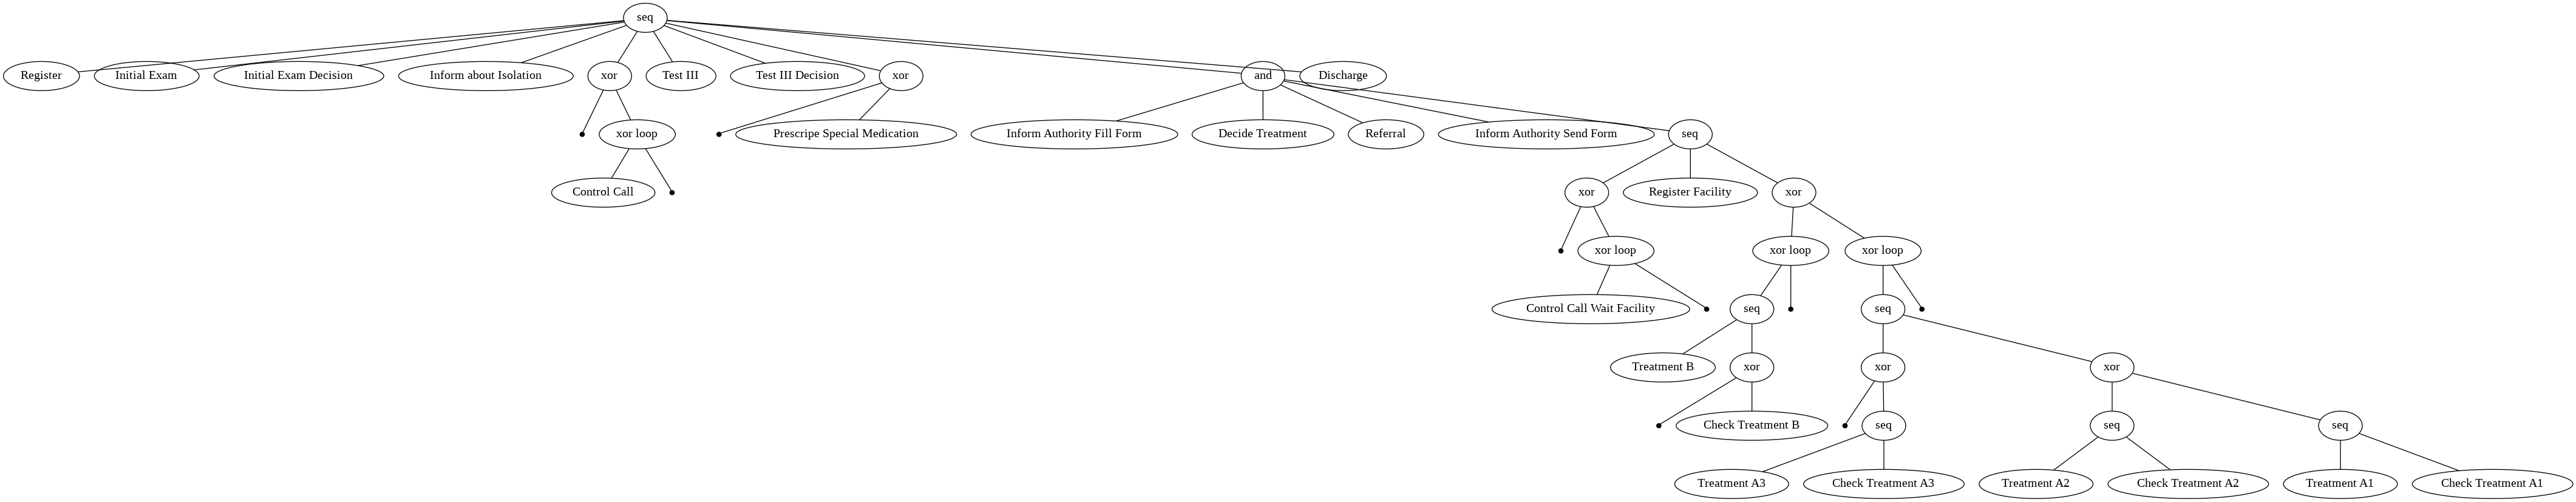

In [40]:
pm4py.view_process_tree(proc_tree)

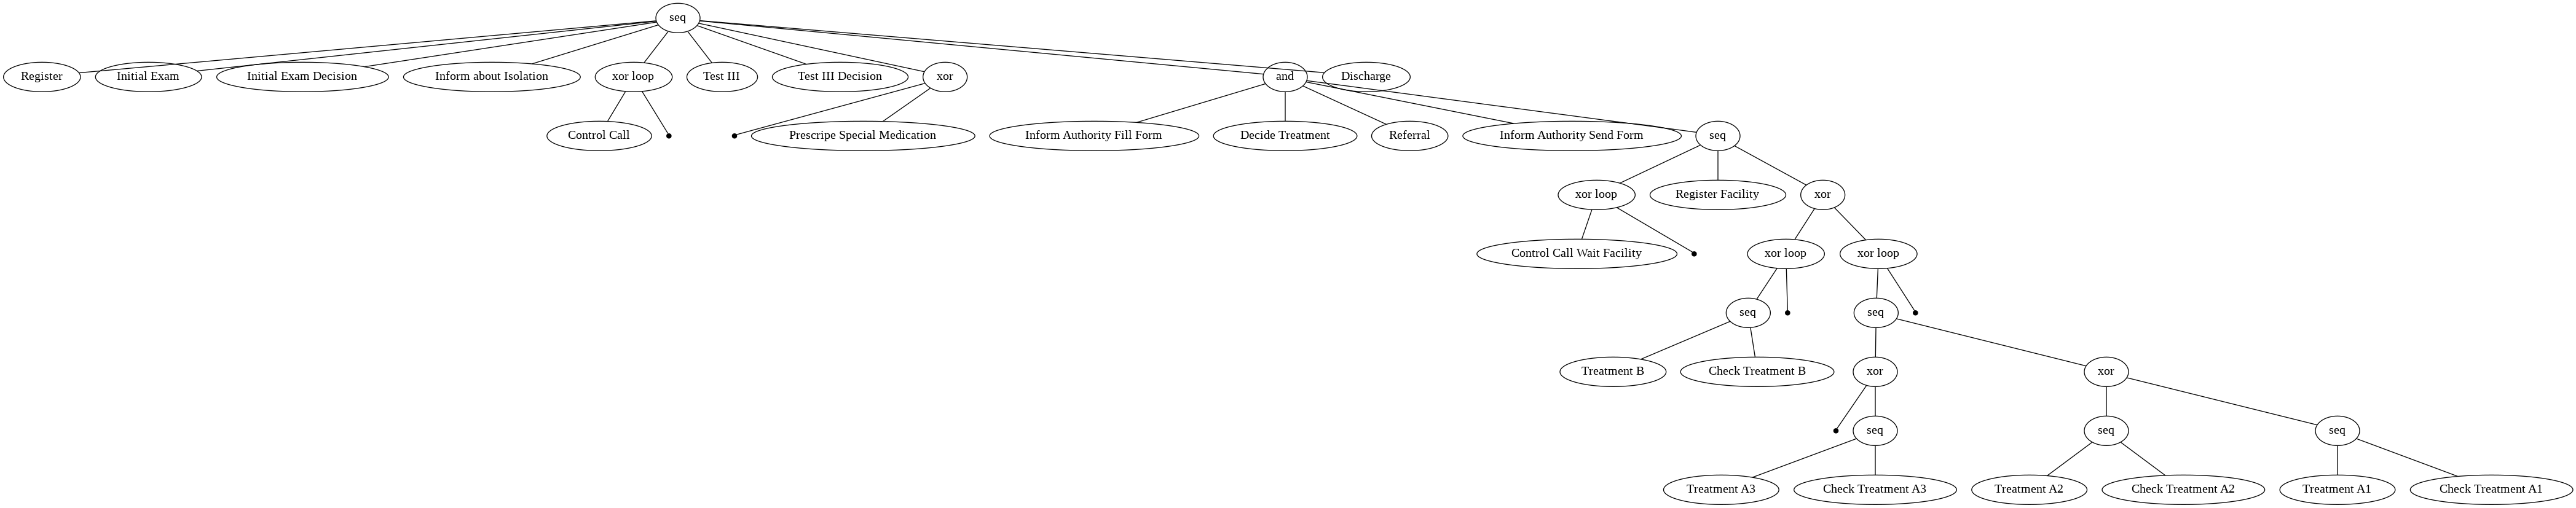

In [41]:
pm4py.view_process_tree(proc_tree_filtered)

In this case, this barely made a difference. 

Finally, discovering a Petri net using Inductive Miner is easy as well

In [42]:
# The net, initial marking, and final marking
net, im, fm = pm4py.discover_petri_net_inductive(log_dis_gen)

And visualize the Petri net

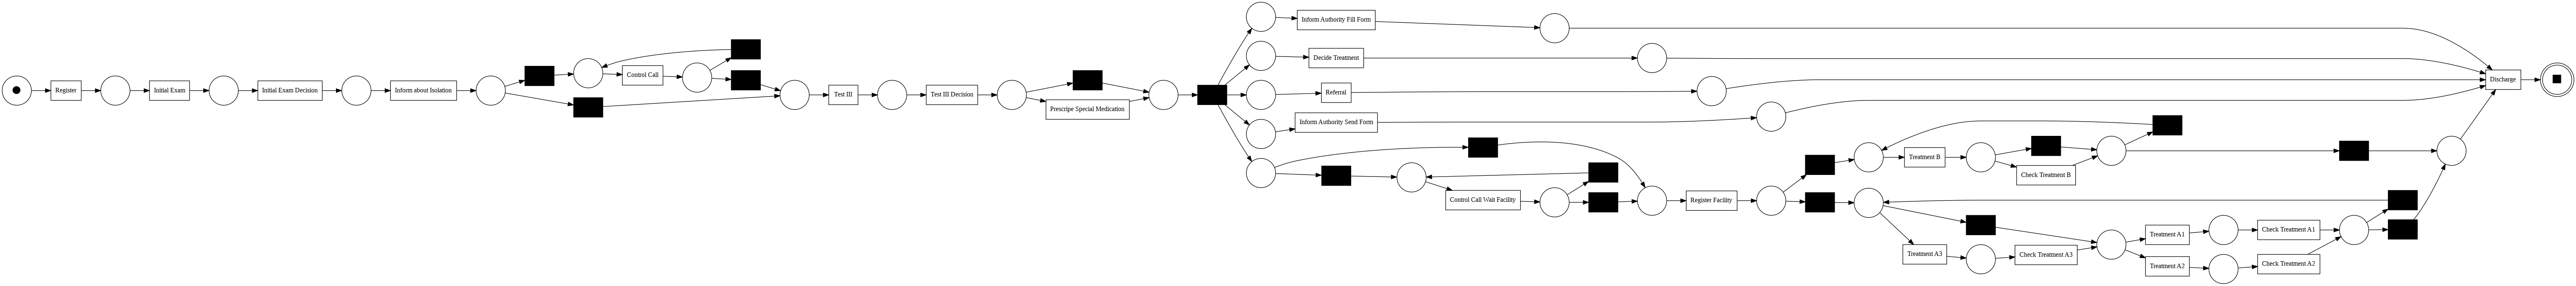

In [43]:
pm4py.view_petri_net(net, im, fm, format='png') 

## Directly-follow graphs
In the lecture, you have also seen another type of a very simple process model: the directly-follow graph. You can create a directly follow graph with pm4py:

In [44]:
dfg, start_activities, end_activities = pm4py.discover_directly_follows_graph(log_dis_gen) 

And then visualize it with frequency information:

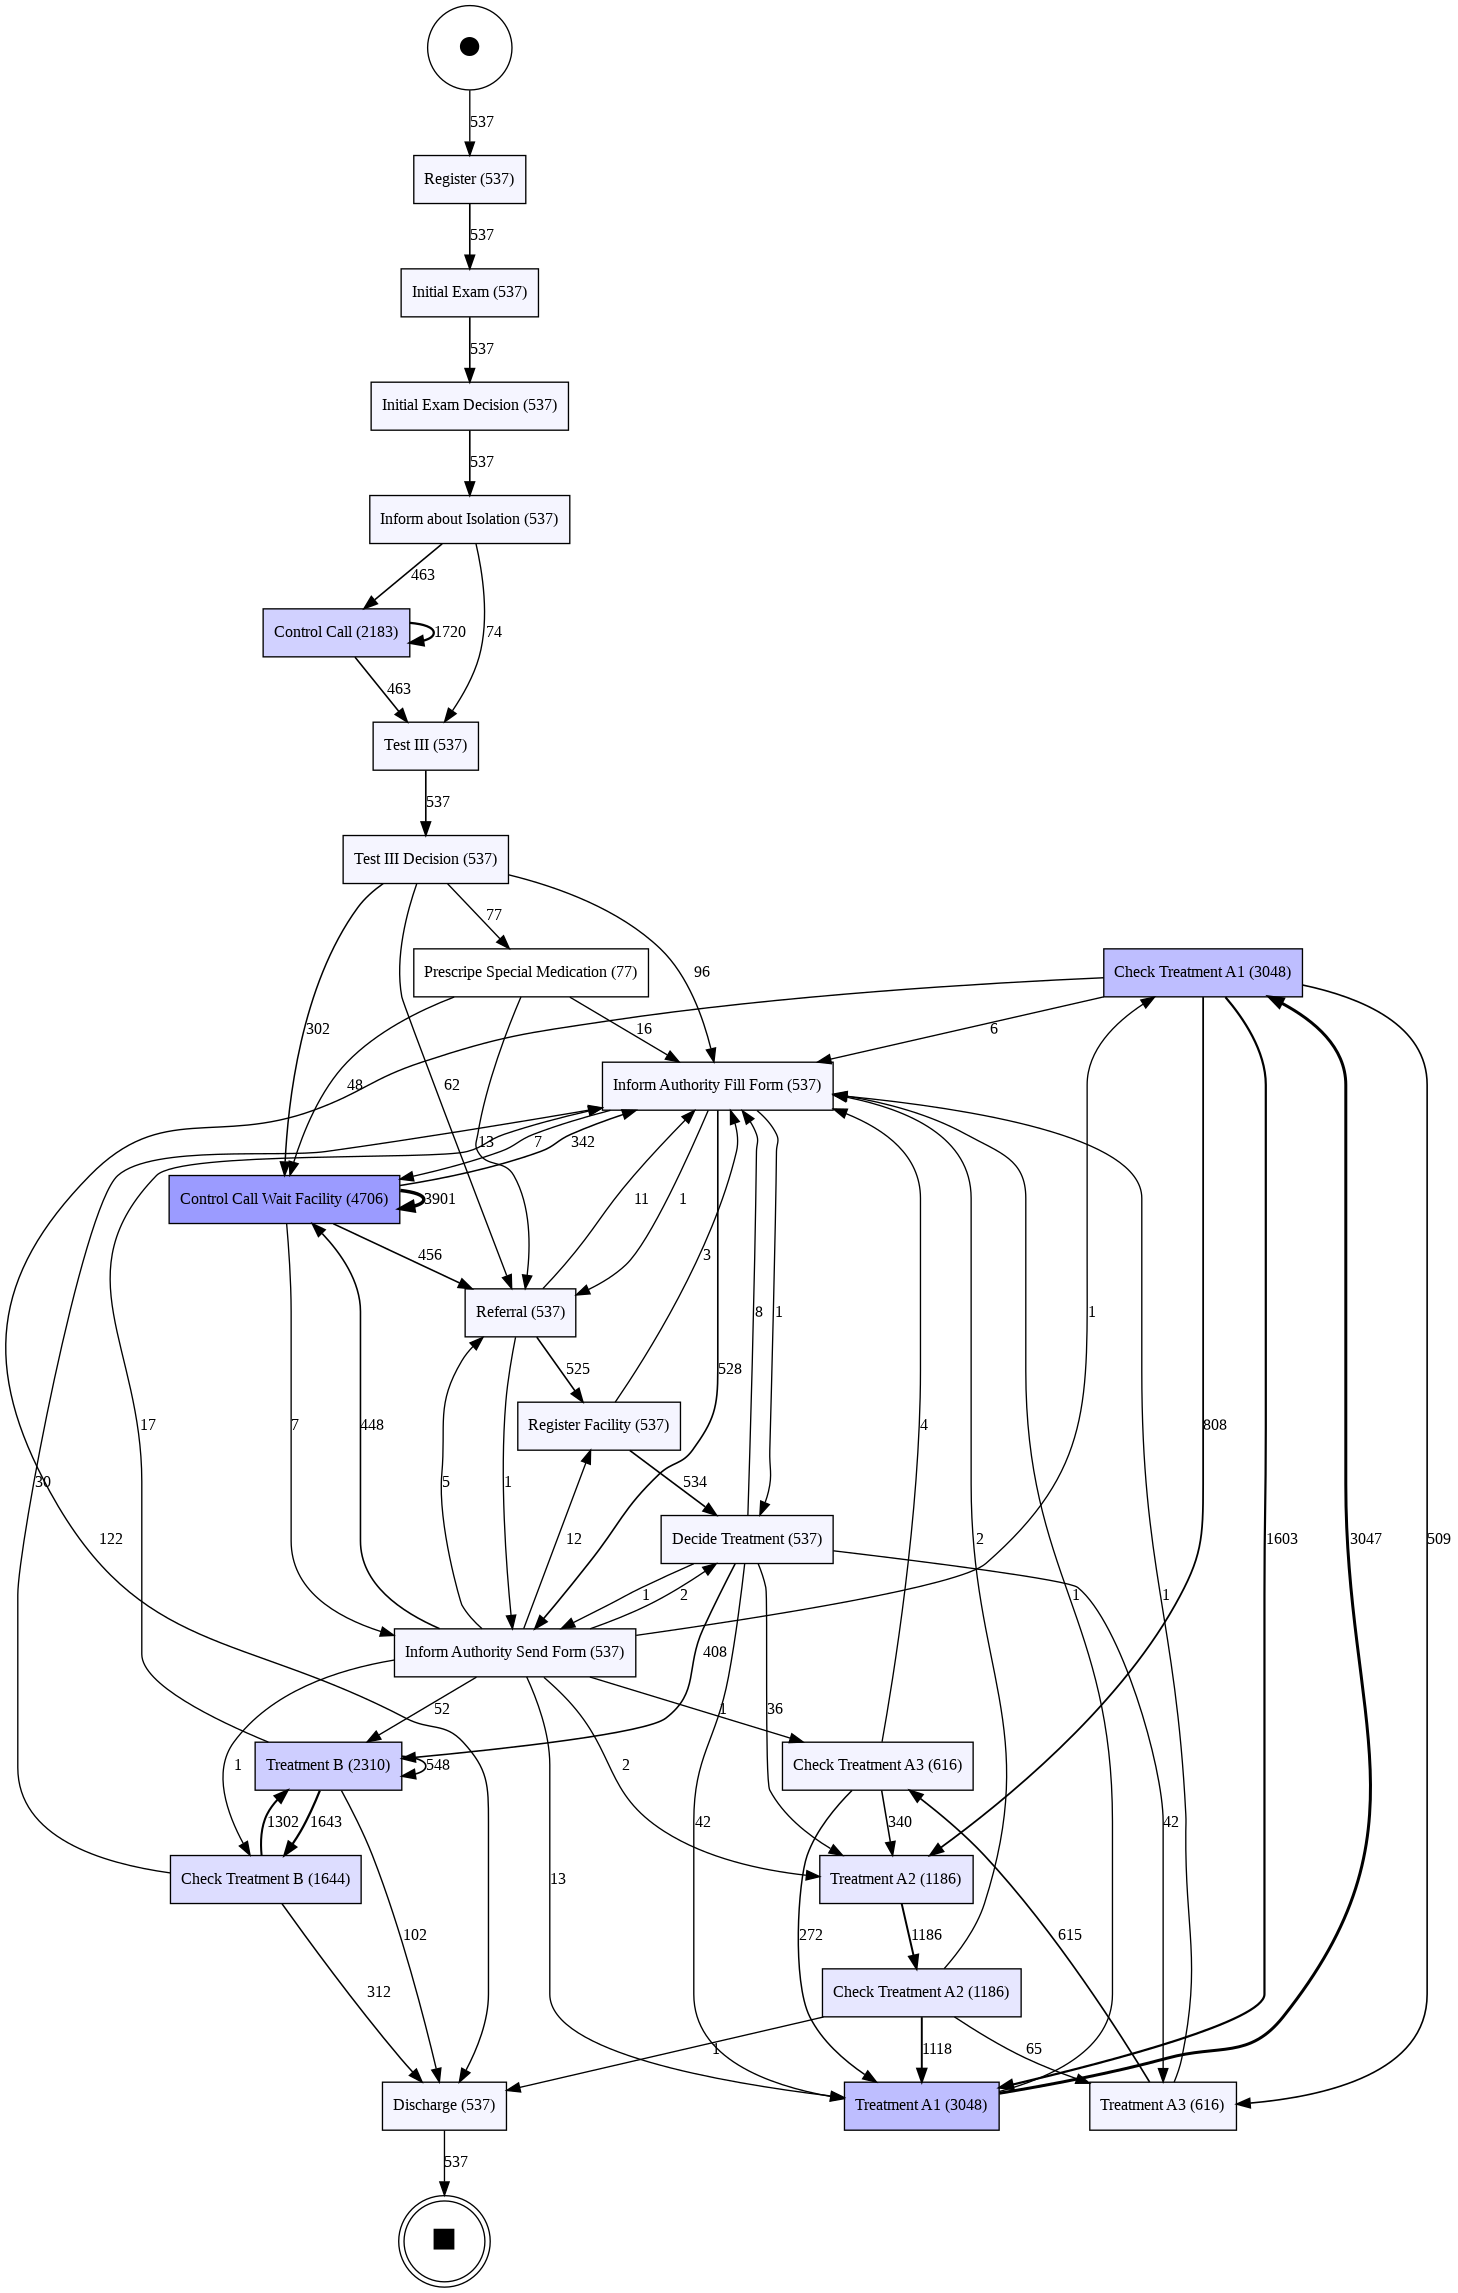

In [45]:
pm4py.view_dfg(dfg, start_activities, end_activities)

# Token-based Replay of an Event Log on a Process Model
Conformance checking accesses to what extend a process model can represent the behavior in an event log. One way to do so on a Petri net is token-based replay, where the event log is replayed on the model measuring the number of produced, consumed, missing, and remaining tokens. 

## Run the Alorithm
Let's compute the token-based replay token counts for `log_dis_gen`.

In [47]:
# Computing token counts
token_replay_result =  pm4py.conformance_diagnostics_token_based_replay(log_dis_gen, net, im, fm)
display(token_replay_result[0])


replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

{'trace_is_fit': True,
 'trace_fitness': 1.0,
 'activated_transitions': [(62d07310-8cdf-47ec-ac46-c3f5d4cbef9e, 'Register'),
  (cf2c9f17-9943-4e40-b5b7-12f7ff1c8e63, 'Initial Exam'),
  (ebfdc8bd-19e9-4dd6-beda-3a49b56ff1ff, 'Initial Exam Decision'),
  (e74aea5e-798d-4cfb-9d6f-acb76505cce6, 'Inform about Isolation'),
  (init_loop_2, None),
  (c9828d3a-2bf4-485e-a8f7-f72469963ce0, 'Control Call'),
  (skip_4, None),
  (c9828d3a-2bf4-485e-a8f7-f72469963ce0, 'Control Call'),
  (skip_4, None),
  (c9828d3a-2bf4-485e-a8f7-f72469963ce0, 'Control Call'),
  (skip_4, None),
  (c9828d3a-2bf4-485e-a8f7-f72469963ce0, 'Control Call'),
  (skip_4, None),
  (c9828d3a-2bf4-485e-a8f7-f72469963ce0, 'Control Call'),
  (skip_5, None),
  (d72f7dcf-6f9c-43d3-8af8-f6ed34b6b133, 'Test III'),
  (a00403ee-abba-4eef-8242-ec69c9708c41, 'Test III Decision'),
  (skip_6, None),
  (tauSplit_7, None),
  (83d8616e-378e-4c8e-b05b-2712cd428a01, 'Inform Authority Fill Form'),
  (1d8fe13f-bb23-4b06-90d4-418bd3dae4f5, 'Inform A

The token-based replay for trace fitness returns an array of results (a result for each trace). As you can see, the results are a dictionaries that provide information on:
- Whether the trace fits the model or not
- The trace fitness score
- The sequence of activated transitions
- The marking reached by the replay
- The transitions enabled on the marking reached by the replay
- The set of transitions where the deviations happened
- The token counts:
  - Missing tokens
  - Consumed tokens
  - Remaining tokens
  - Produced tokens


# Frequency And Performance
Petri nets can be decorated with frequency and performance information

In [48]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

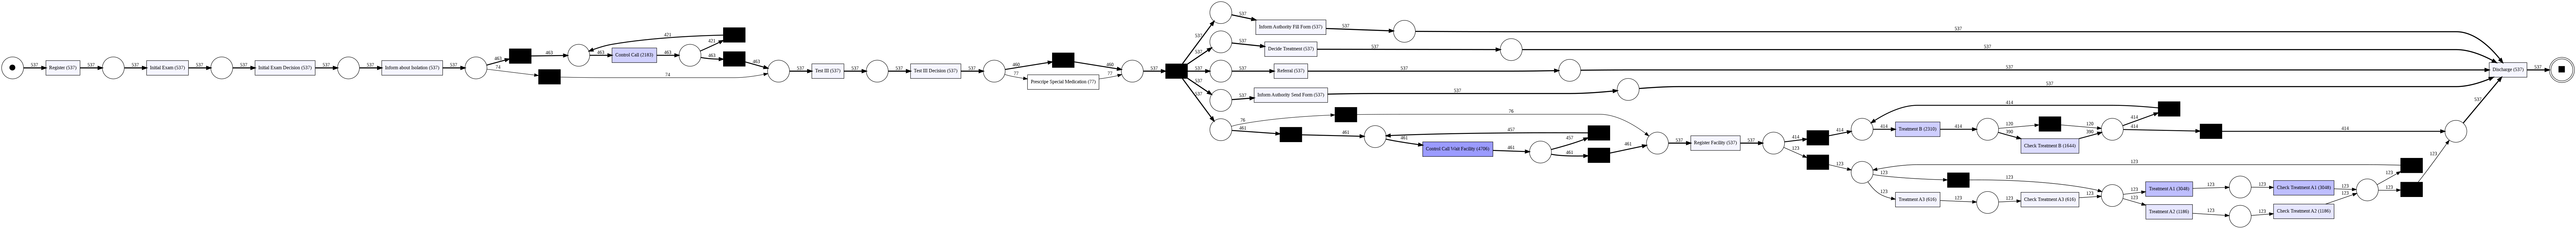

In [49]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.FREQUENCY, log=log_dis_gen)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/413 [00:00<?, ?it/s]

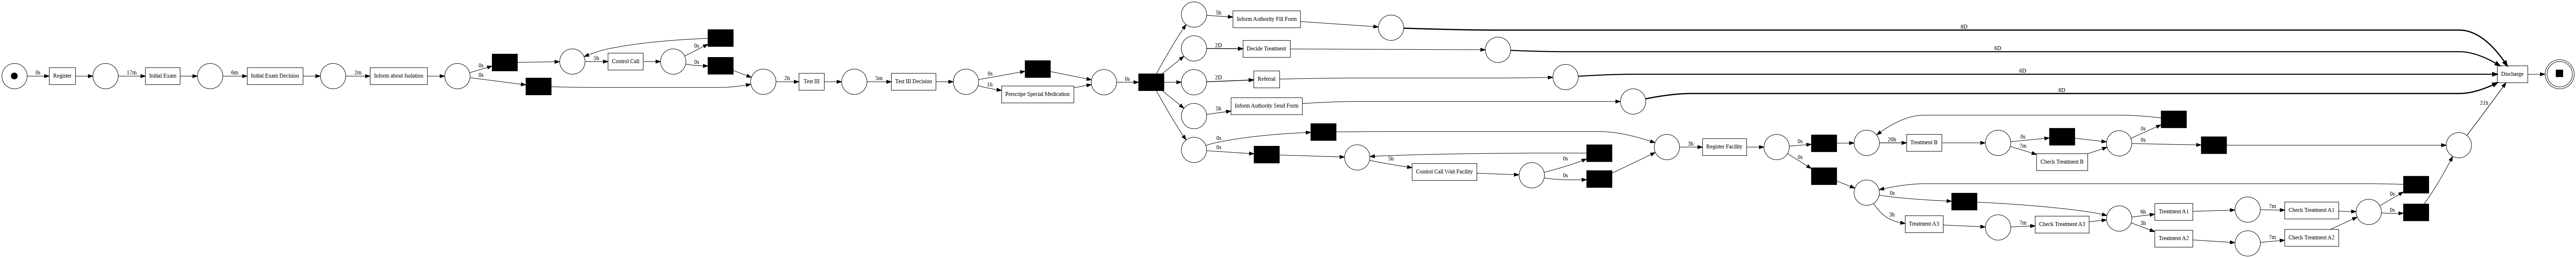

In [50]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm, parameters=parameters, variant=pn_visualizer.Variants.PERFORMANCE, log=log_dis_gen)
pn_visualizer.view(gviz)

# Your Turn
Try to work on the following few tasks. You will either have to use some of the concept introduced above or some basic pandas skills :) .

1. How many different Baludins do we have?

2. Show a process model for the treatment event log (`log_treat`) (Use IM with parameters of your choice).

3. Show the fitness for your model.

4. Show your model decorated with frequencies.

5. Consider the cases where special medication is prescriped. Compare them to the cases without special medication.

*Hint: To get a quick overview, you may want to consider their DFGs*.

6. Extract the top 5% of the longest cases (in terms of number of activities) and show their DFG